In [1]:
from collections import namedtuple
import functools
from glob import glob

import torch
import torch.nn as nn

CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, diameter_mm, series_uid, center_xyz'
)


In [2]:
import csv
from math import sqrt

@functools.lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=True):
    mhd_list = glob('./data/subset0/*.mhd')
    # [:-4] removes the '.mhd' from the end of the filenames
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}

    diameter_dict = {}
    with open('data/annotations.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])
            
            # Here, if the series_uid doesn't already exist in the dict we set it to []
            # Otherwise we just append the new data, so each uid has a list of the associated
            # nodules 
            
            diameter_dict.setdefault(series_uid, []).append(
                (annotationCenter_xyz, annotationDiameter_mm)
            )
    
    candidateInfo_list = []
    
    with open('data/candidates.csv', 'r') as f:
        reader = list(csv.reader(f))
        print(reader[0])
        for row in reader[1:]:
            series_uid = row[0]
            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue

            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])
            
            candidateDiameter_mm = 0.0
            for annotation_tup in diameter_dict.get(series_uid, []): 
                # second arg in dict.get() is the default
                annotationCenter_xyz, annotation_Diameter_mm = annotation_tup
                
                delta_mms = [abs(candidateCenter_xyz[i] - annotationCenter_xyz[i]) 
                            for i in range(3)]
                
                delta_mm = sqrt(sum([x ** 2 for x in delta_mms]))
                
                if delta_mm > annotation_Diameter_mm / 2:
                    break
                else: 
                    candidateDiameter_mm = annotation_Diameter_mm
                    break
                
            candidateInfo_list.append(CandidateInfoTuple(
                isNodule_bool,
                candidateDiameter_mm,
                series_uid,
                candidateCenter_xyz
            ))
    candidateInfo_list.sort(reverse=True) 
           
    return candidateInfo_list
                                
getCandidateInfoList()[:2]

['seriesuid', 'coordX', 'coordY', 'coordZ', 'class']


[CandidateInfoTuple(isNodule_bool=True, diameter_mm=25.23320204, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273', center_xyz=(63.4740118048, 73.9174523314, -213.736128767)),
 CandidateInfoTuple(isNodule_bool=True, diameter_mm=25.23320204, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273', center_xyz=(59.1136546856, 82.9816128068, -213.127954744))]

In [3]:
# Files would usually be in the more difficult DICOM format
# but for this challenge pre-converted into MetaIO, parsed with SimpleITK

import SimpleITK as sitk
import numpy as np

class Ct:
    def __init__(self, series_uid):
        mhd_path = glob(f'data/subset0/{series_uid}.mhd')[0]
        
        ct_mhd = sitk.ReadImage(mhd_path)
        # this call gets data from the .raw file without us having to
        # reference it directly
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
        
        self.hu_a = ct_a
        self.series_uid = series_uid


In [4]:
test_uid = getCandidateInfoList()[0].series_uid
test_ct = Ct(test_uid)
test_ct.hu_a[50, :, :]

array([[-2048., -2048., -2048., ..., -2048., -2048., -2048.],
       [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
       [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
       ...,
       [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
       [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
       [-2048., -2048., -2048., ..., -2048., -2048., -2048.]],
      dtype=float32)

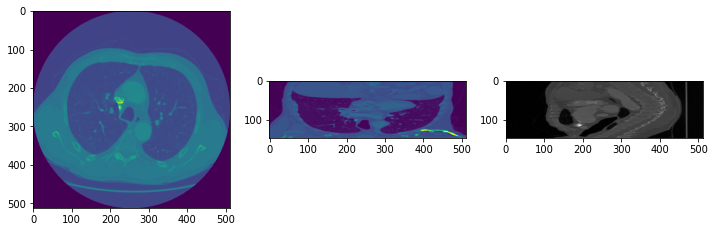

In [5]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3)
axs[0].imshow(test_ct.hu_a[100, :, :])
axs[1].imshow(test_ct.hu_a[:, 250, :])
axs[2].imshow(test_ct.hu_a[:, :, 250], cmap='gray')
fig.set_size_inches(12, 10)

In [6]:
# CT scan voxel values are expressed in Housfield units, HU
# it's something like a density, where air is about -1000,
# water is 0 HU (1g/cm3) and bone is at least +1,000HU (2-3g/cm3)
# Generally stored as signed 12 bit integers (range of 4096)

# Patient coordinate system is:
# Positive X is patient left
# Positive Y is patient posterior
# Positive Z is patient head
# measured in mm with an arbitrary origin not corresponding to the origin
# of the voxel array

# IRC has:
# index positive I is head
# row positive R is posterior
# column positive C is right


# normal for the voxel coords to have same x and y units
# and for the z to have larger, eg 1.125mm x 1.125mm x 2.5mm

In [7]:
# namedtuple can be delineated with either list of strings 
# or one string separated by spaces or commas
# i think the spaces convention is used in particular for assigning names
# to the result of csv.reader() rows
# namedtuples have a ._make() function
# can neatly to map(NameT._make, csv.reader(f)) to convert all :P

IrcTuple = namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = namedtuple('XyzTuple', ['x', 'y', 'z'])

def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    cri_a = np.array(coord_irc)[::-1] # we're only talking about a single vector here, so just need to flip it
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coords_xyz = (direction_a @ (cri_a * vxSize_a) + origin_a)
    return XyzTuple(*coords_xyz)

def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a).astype(int)[::-1]
    return IrcTuple(*cri_a)


In [8]:
class Ct:
    def __init__(self, series_uid):
        mhd_path = glob(f'data/subset0/{series_uid}.mhd')[0]
        
        ct_mhd = sitk.ReadImage(mhd_path)
        # this call gets data from the .raw file without us having to
        # reference it directly
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
        
        self.hu_a = ct_a
        self.series_uid = series_uid

        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)

    def getRawCandidate(self, center_xyz, width_irc):
        # so we get the center of the candidate in IRC coords
        center_irc = xyz2irc(
            center_xyz,
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a
        )
        
        slice_list = []
        # we get the center and axis number in IRC coords
        for axis, center_val in enumerate(center_irc):
            # getting the bounding box of the candidate
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])
            slice_list.append(slice(start_ndx, end_ndx))
        
        # builds up the way that we're eventually going to slice the main CT
        # tuple of slices acts as is we have them comma separated
    
        ct_chunk = self.hu_a[tuple(slice_list)]
        
        # needs to also deal here with cases where the center and width put edges 
        # outside the actual CT scan
        
        return ct_chunk, center_irc

In [9]:
Ct(getCandidateInfoList()[0].series_uid)

In [10]:
# here's the util code that does the slightly rogue caching

import gzip  # core lub for zipping and unzipping

from cassandra.cqltypes import BytesType

from diskcache import FanoutCache, Disk, core
from diskcache.core import io
from io import BytesIO
from diskcache.core import MODE_BINARY

# from util.logconf import logging
# log = logging.getLogger(__name__)
# # log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
# # log.setLevel(logging.DEBUG)

class GzipDisk(Disk):
    def store(self, value, read, key=None):
        """
        Override from base class diskcache.Disk.

        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.

        :param value: value to convert
        :param bool read: True when value is file-like object
        :return: (size, mode, filename, value) tuple for Cache table
        """
        # pylint: disable=unidiomatic-typecheck
        if type(value) is BytesType:
            if read:
                value = value.read()
                read = False

            str_io = BytesIO()
            gz_file = gzip.GzipFile(mode='wb', compresslevel=1, fileobj=str_io)

            for offset in range(0, len(value), 2**30):
                gz_file.write(value[offset:offset+2**30])
            gz_file.close()

            value = str_io.getvalue()

        return super(GzipDisk, self).store(value, read)


    def fetch(self, mode, filename, value, read):
        """
        Override from base class diskcache.Disk.

        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.

        :param int mode: value mode raw, binary, text, or pickle
        :param str filename: filename of corresponding value
        :param value: database value
        :param bool read: when True, return an open file handle
        :return: corresponding Python value
        """
        value = super(GzipDisk, self).fetch(mode, filename, value, read)

        if mode == MODE_BINARY:
            str_io = BytesIO(value)
            gz_file = gzip.GzipFile(mode='rb', fileobj=str_io)
            read_csio = BytesIO()

            while True:
                uncompressed_data = gz_file.read(2**30)
                if uncompressed_data:
                    read_csio.write(uncompressed_data)
                else:
                    break

            value = read_csio.getvalue()

        return value

def getCache(scope_str):
    return FanoutCache('data-unversioned/cache/' + scope_str,
                       disk=GzipDisk,
                       shards=64,
                       timeout=1,
                       size_limit=3e11,
                       # disk_min_file_size=2**20,
                       )
    


raw_cache = getCache('part2ch10_raw')

In [11]:
# @functools.lru_cache(1, typed=True)
def getCt(series_uid):
    return Ct(series_uid)

@raw_cache.memoize(typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc = Ct(series_uid).getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc

In [12]:
import copy

from torch.utils.data import Dataset

class LunaDataset(Dataset):
    def __init__(self, 
                 val_stride=0,
                 isValSet_bool=None,
                 series_uid=None):
        super().__init__()
        self.candidateInfo_list = copy.copy(getCandidateInfoList())
        
        if series_uid:
            self.candidateInfo_list = [
                x for x in self.candidateInfo_list if x.series_uid == series_uid
            ]

        if isValSet_bool:
            assert val_stride >0, val_stride
            self.candidateInfo_list = self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
        elif val_stride > 0:
            del self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
            
    
    def __len__(self):
        return len(self.candidateInfo_list)
    
    def __getitem__(self, ndx):
        candidateInfo_tup = self.candidateInfo_list[ndx]
        width_irc = (32, 48, 48)
        
        candidate_a, center_irc = getCtRawCandidate(
            candidateInfo_tup.series_uid,
            candidateInfo_tup.center_xyz,
            width_irc,
        )
        
        candidate_t = torch.from_numpy(candidate_a)
        candidate_t = candidate_t.to(torch.float32)
        candidate_t = candidate_t.unsqueeze(0)
        
        pos_t = torch.tensor([
            not candidateInfo_tup.isNodule_bool,
            candidateInfo_tup.isNodule_bool
            ],
            dtype=torch.long,
        )
                             
                             
        
        return (
            candidate_t, # 1((CO10-1))??
            pos_t, # 1((CO10-2))??
            candidateInfo_tup.series_uid,
            torch.tensor(center_irc)
        )

In [13]:
LunaDataset()[0]
# Chapt#######lllllkkok4fre

(tensor([[[[-673., -779., -869.,  ..., -868., -826., -840.],
           [-719., -778., -787.,  ..., -825., -778., -799.],
           [-766., -759., -672.,  ..., -794., -742., -784.],
           ...,
           [-705., -692., -733.,  ...,  225.,  322.,  393.],
           [-668., -655., -672.,  ...,  611.,  576.,  503.],
           [-637., -638., -650.,  ...,  576.,  426.,  323.]],
 
          [[-814., -844., -868.,  ..., -816., -818., -833.],
           [-874., -865., -839.,  ..., -815., -827., -844.],
           [-919., -885., -819.,  ..., -838., -827., -845.],
           ...,
           [-760., -750., -713.,  ...,   -5.,   11.,   -4.],
           [-717., -725., -676.,  ...,  108.,  110.,   61.],
           [-693., -692., -679.,  ...,  278.,  219.,  165.]],
 
          [[-951., -954., -947.,  ..., -872., -864., -858.],
           [-949., -953., -941.,  ..., -853., -846., -850.],
           [-928., -940., -920.,  ..., -827., -823., -833.],
           ...,
           [-698., -727., -761.

In [14]:
candidateInfo_list = getCandidateInfoList(requireOnDisk_bool=False)
positiveInfo_list = [x for x in candidateInfo_list if x[0]]
diameter_list = [x[1] for x in positiveInfo_list]
len(positiveInfo_list), candidateInfo_list[0], diameter_list[0]

['seriesuid', 'coordX', 'coordY', 'coordZ', 'class']


(1351,
 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(58.2, 35.69, -102.08)),
 30.61040636)

<IPython.core.display.Javascript object>

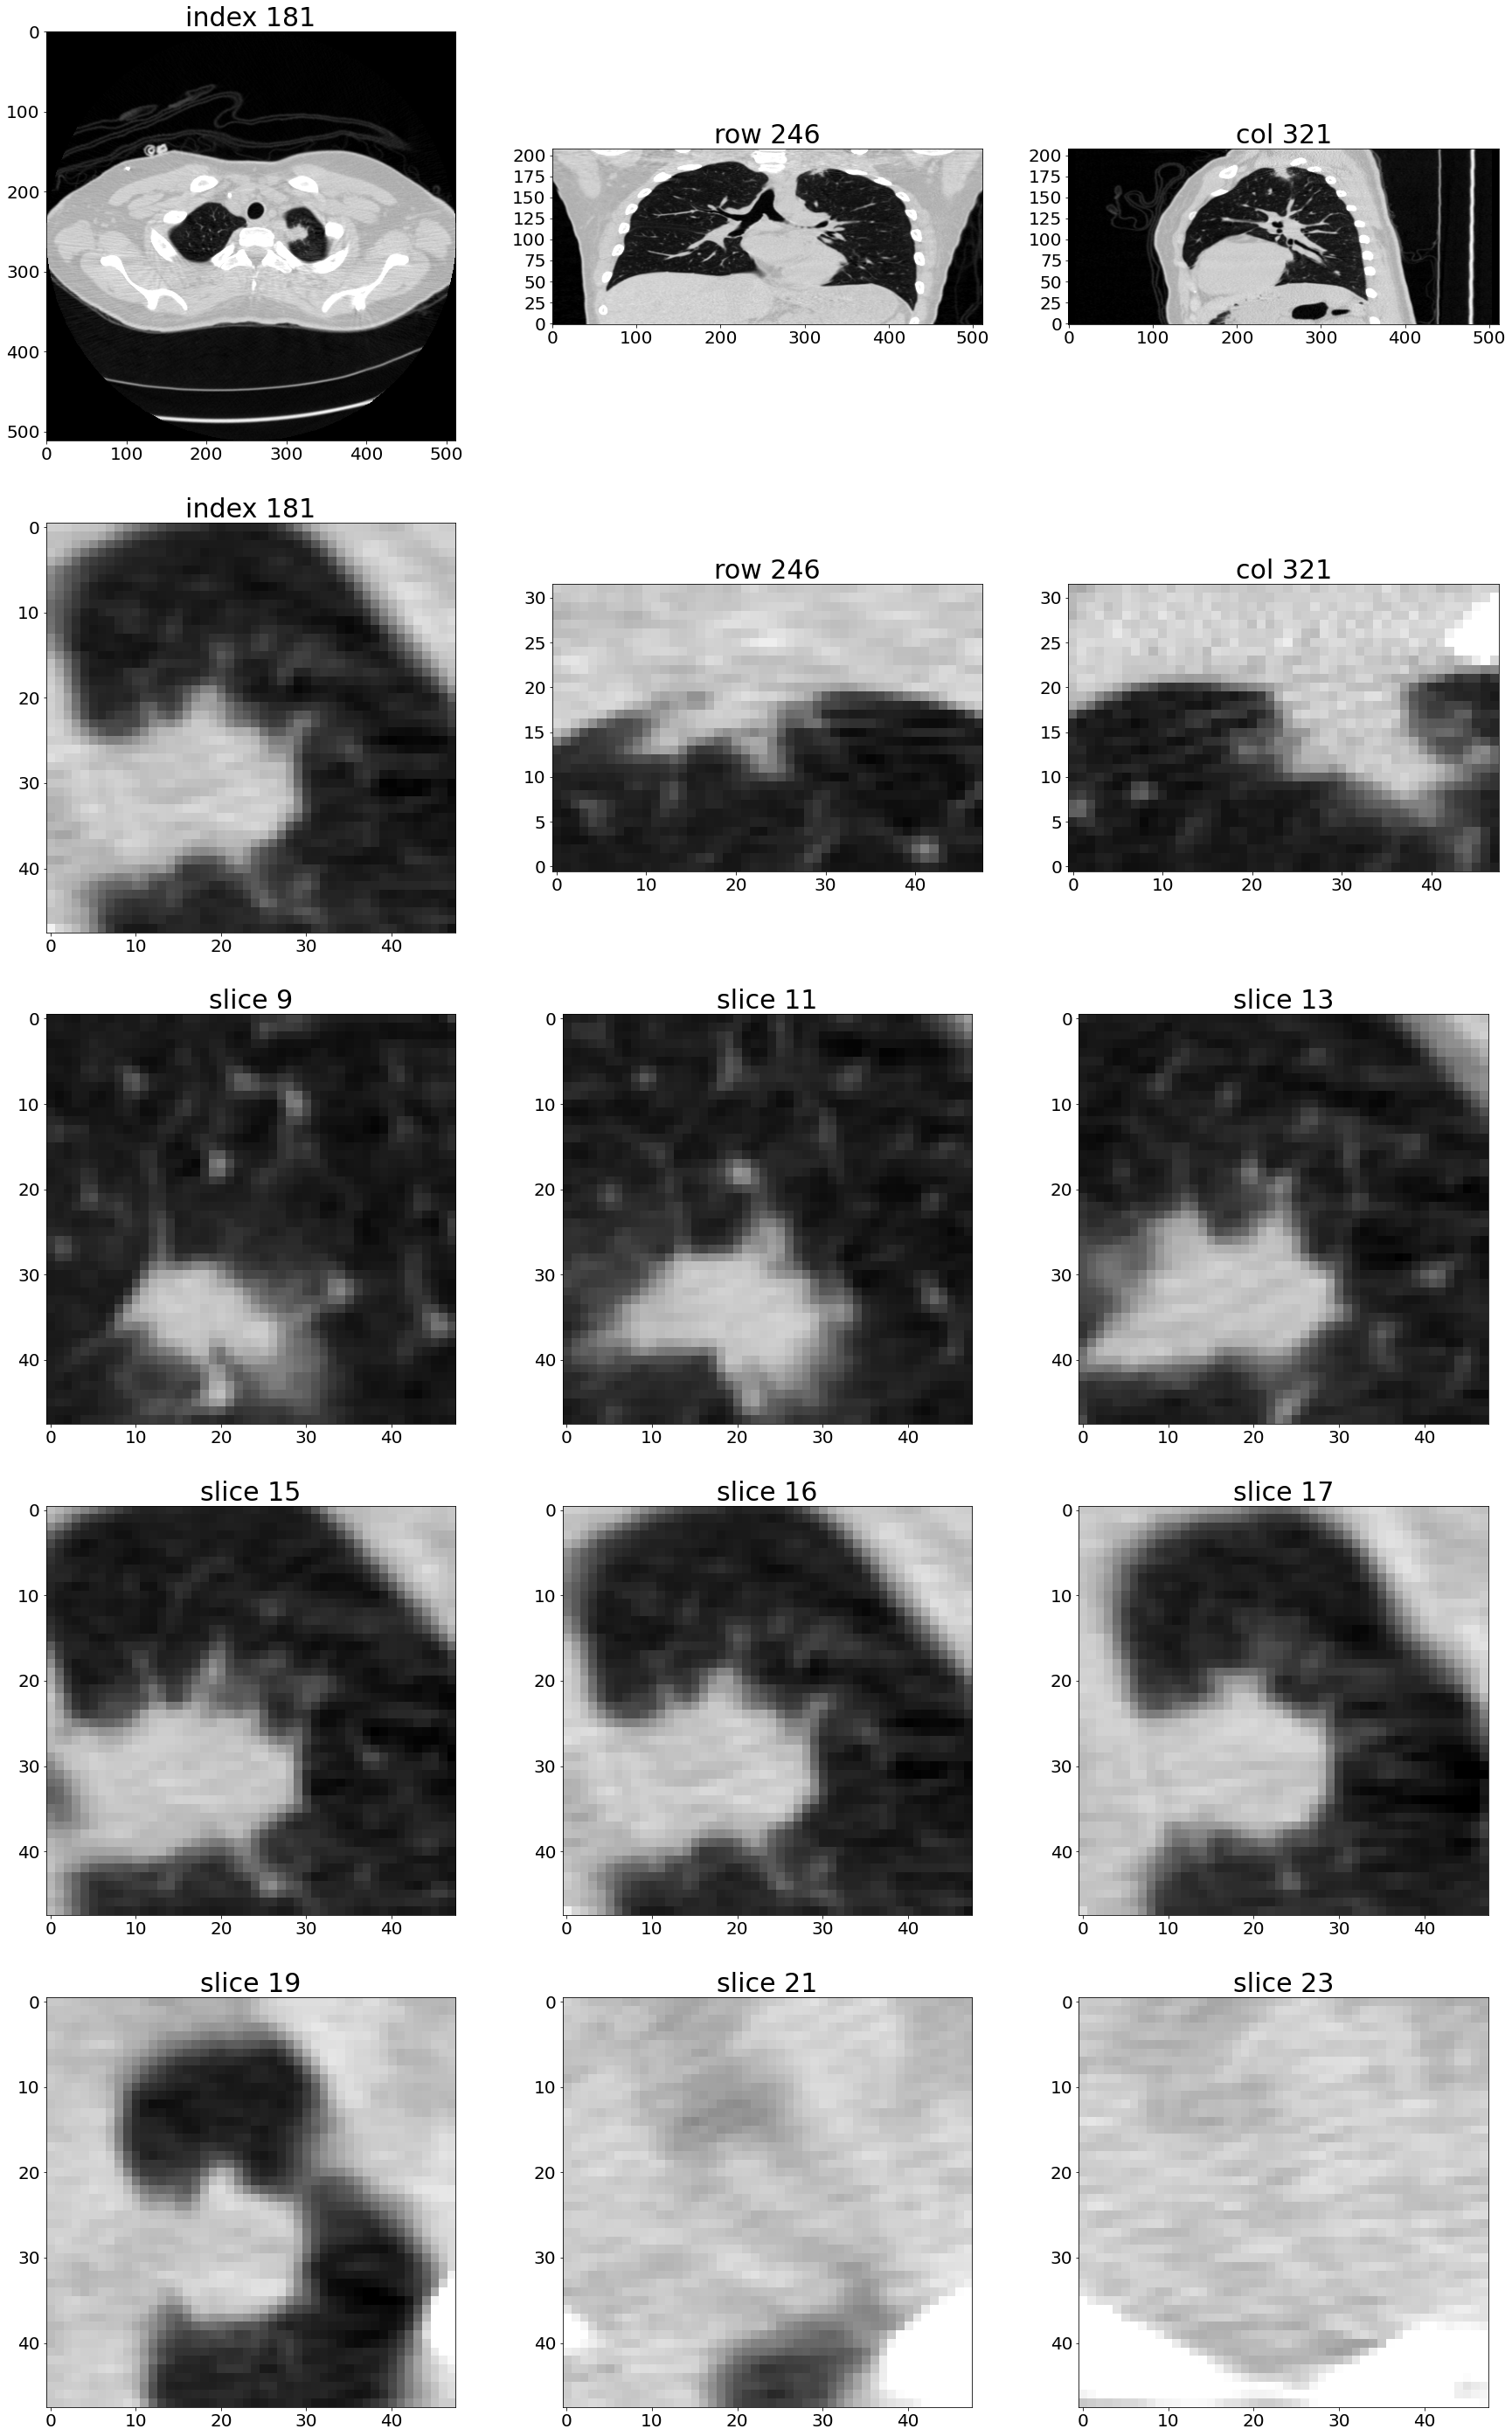

In [15]:
%matplotlib inline
from vis import findPositiveSamples, showCandidate
positiveSample_list = findPositiveSamples()
series_uid = positiveSample_list[11][2]
showCandidate(series_uid)

In [17]:
# Exercises


# 1. Implement a program that iterates though a LunaDataset instance, and
# time how long it takes to do so. In the interest of time,
# it might make sense to have an option to limit the iterations to the 
# the first 1000 samples.

import time

luna = LunaDataset()
print(len(luna))
start_t = time.time()
for n in range(len(luna)):
    luna_n = luna[n]
    if n % 100 == 0:
        print(f'Elapsed after {n}: {time.time() - start_t}')
        if n % 2000 == 0 and n > 0:
            break


# first time running, with the caching copied directly from the textbook,
# loads about 100 every 7s after 35s of startup.
# near instant to do the first 1000 the second time, 1000 loaded in 0.3s

# without the lru_cache(1, typed=True) is waaay faster the first time around
# doesnt improve on repeated attempts but i think that it's still faster than with it?

# difference between caching in memory (RAM) and on disk is very important
# the raw_cache using the diskcache module is, unsurprisingly, on disk, whereas the 
# functools.lru_cache 

56938
Elapsed after 0: 0.0017096996307373047
Elapsed after 100: 0.032283782958984375
Elapsed after 200: 0.05681633949279785
Elapsed after 300: 0.08263349533081055
Elapsed after 400: 0.10728168487548828
Elapsed after 500: 0.131744384765625
Elapsed after 600: 0.15732407569885254
Elapsed after 700: 0.18112540245056152
Elapsed after 800: 0.20606040954589844
Elapsed after 900: 0.23075103759765625
Elapsed after 1000: 0.25430941581726074
Elapsed after 1100: 0.27900242805480957
Elapsed after 1200: 0.30280590057373047
Elapsed after 1300: 0.32700395584106445
Elapsed after 1400: 0.34908413887023926
Elapsed after 1500: 0.37108755111694336
Elapsed after 1600: 0.39507579803466797
Elapsed after 1700: 0.41974377632141113
Elapsed after 1800: 0.44539594650268555
Elapsed after 1900: 0.46942734718322754
Elapsed after 2000: 0.49411582946777344


In [ ]:
# Chapter 11

